In [1]:
# !pip install -e . peax

# Green House Production
## Artificial Lightning Control
Over the years the greenhouse grower has gained plenty of experience to know when to turn on the assimilation lightning and when not to. 

However, he is tired of switching the light on and off himself and thinks this process is ready to be automated. 

Do you agree with him that this process can be automated? 

Let’s look at the data and see what they suggest!!!

Due to incompatibility among parquet libraries, jupyter and iOS,  I've decided that the easiest way to show the data on a notebook, is to load in the the terminal and then save as a csv.  
I've used the following snip of code in the terminal:

In [2]:
from peax.src.preprocess import PreProcess
pp = PreProcess()
pp.preprocess()

# Assimilation Lightning Parameters
The parameter we have to look over to see when the lights are turn on and off is called AssimLight 

AssimLight is a binary value (0/100) if the HPS lamps are turned on and off

Let’s look at the first week of the data:

15:11 INFO     [15:11] ArtificialLighting: INFO  : Loading conditions                         ]8;id=418387;file:///Users/mattiacinelli/repositories/PeaxdataChallenge/peax/src/artificiallight.py\artificiallight.py]8;;\:]8;id=640905;file:///Users/mattiacinelli/repositories/PeaxdataChallenge/peax/src/artificiallight.py#26\26]8;;\

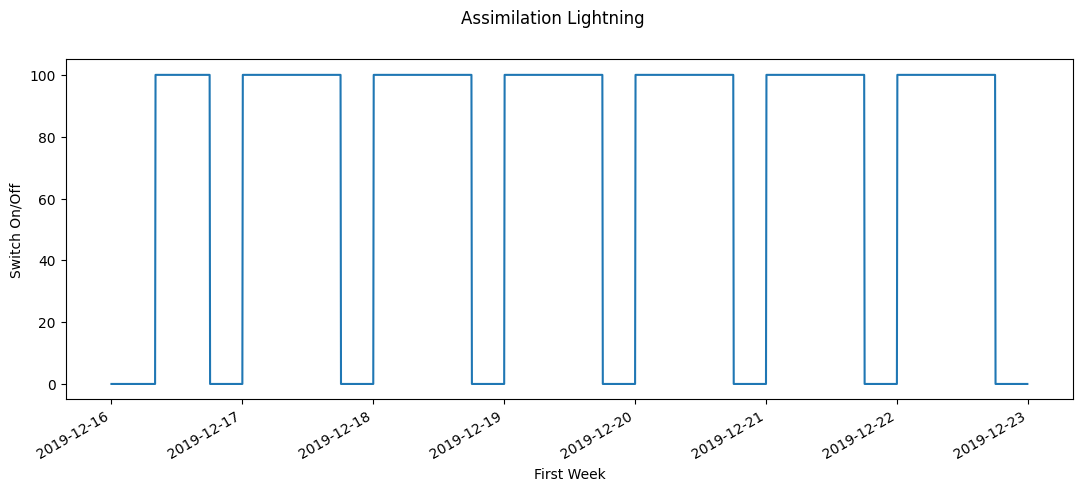

In [3]:
from peax.src.artificiallight import ArtificialLighting

al = ArtificialLighting()
conditions = al.load_conditions()

first_week = conditions.loc['2019-12-16 00:00:00':'2019-12-23 00:00:00']
first_week = first_week[:-1]
first_week.head()

al.plot_data(
    data=first_week['AssimLight'], 
    title='Assimilation Lightning', 
    xlabel='First Week', 
    ylabel='Switch On/Off',
    fig_name='commons/AssimLight_1w.jpg'
)

The timing seems consistent

Let’s investigate the whole period

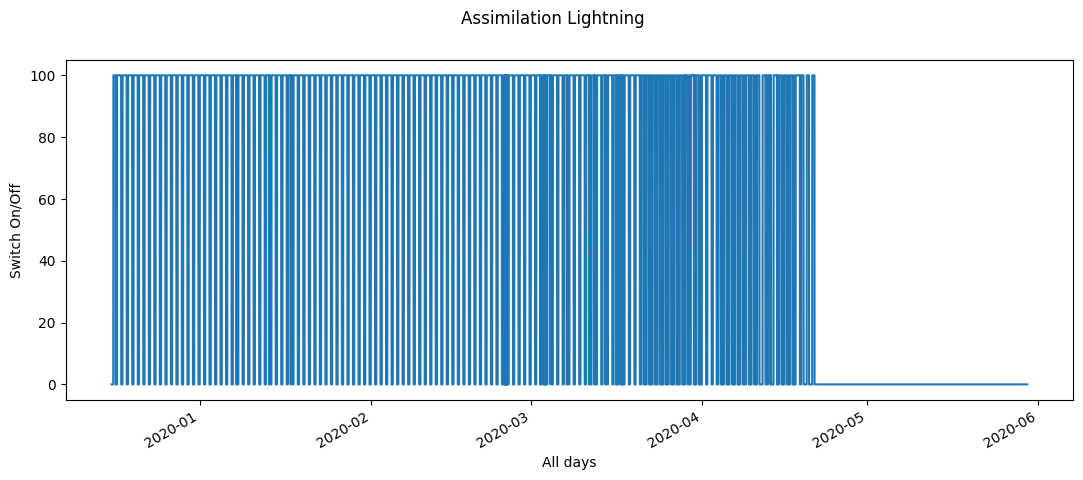

In [4]:
al.plot_data(
    data = conditions['AssimLight'],
    title = 'Assimilation Lightning',
    xlabel = 'All days',
    ylabel = 'Switch On/Off',
    fig_name ='commons/AssimLight_all.jpg'
)

We can see that the illumination stay consistent until April the 22nd then the lights are kept off for the rest of the experiment:


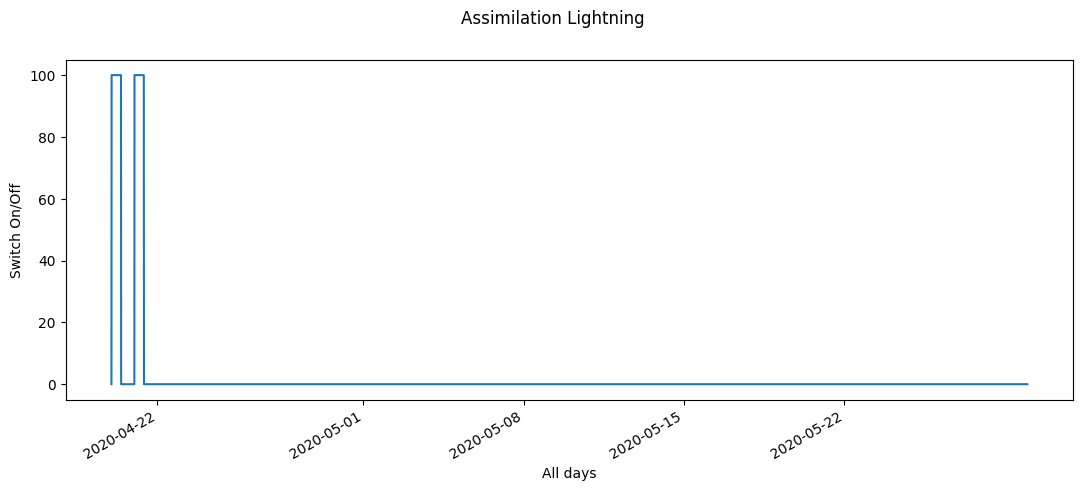

In [5]:
al.plot_data(
    data = conditions.loc['2020-04-20 00:00:00':]['AssimLight'],
    title = 'Assimilation Lightning',
    xlabel = 'All days',
    ylabel = 'Switch On/Off',
    fig_name = 'commons/AssimLight_last_period.jpg'
)

# Solar radiation
HPS lamps provide illumination in a green house to provide for the lack of sunlight in the darker seasons (I assume that the lights have no intended use as heath regulation, although it maybe not be true nor it impact in plant growth negligible).

It is safe to assume that the grower has consider the lamps unnecessary after April the 22nd.

The solar radiation is measured by the parameter Iglob in Watts per meter square.

Therefore, let’s investigate how the strength of sunlight correlate timewise with the use of artificial illumination.

As expected, the solar radiation grows towards the summer.

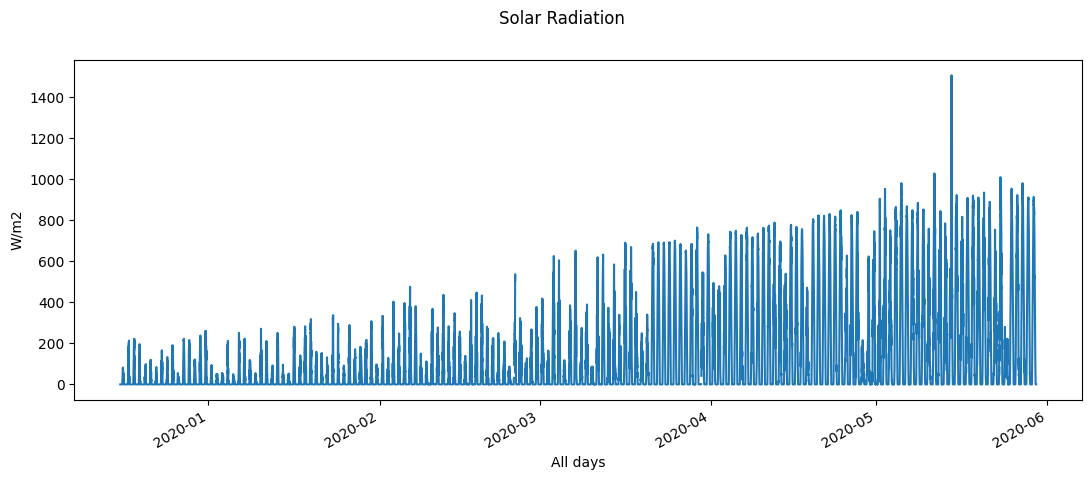

In [6]:
al.plot_data(
    data = conditions['Iglob'],
    title = 'Solar Radiation',
    xlabel = 'All days',
    ylabel = 'W/m2',
    fig_name = 'commons/Solar_radiation_all.jpg'
)

But what is the solar radiation the day the light are turned off?

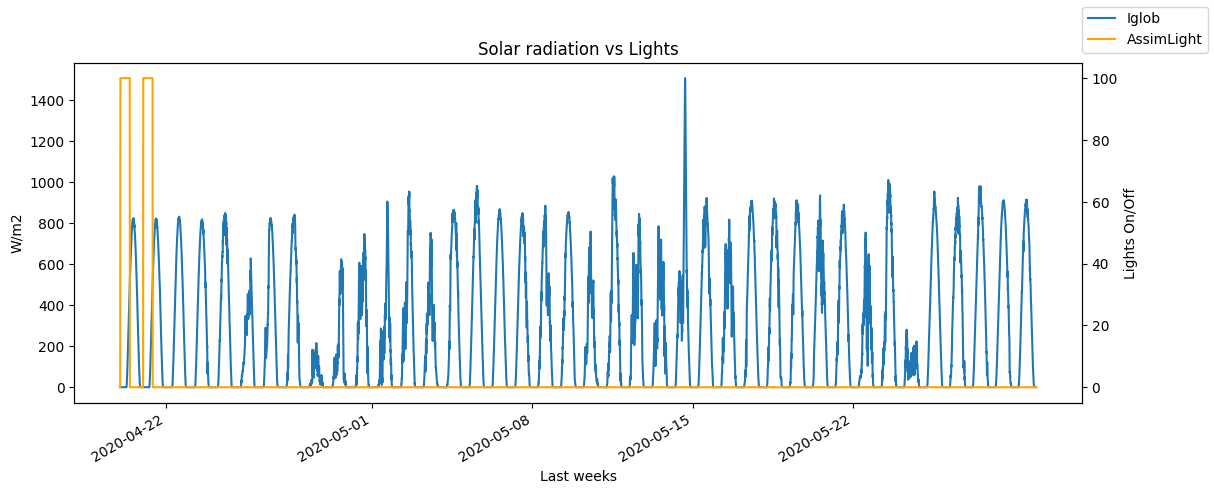

In [7]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(13, 5))

ax = conditions.loc['2020-04-20 00:00:00':]['Iglob'].plot(y="column1", legend=False)
ax.set_xlabel('Last weeks')
ax.set_title('Solar radiation vs Lights')
ax.set_ylabel('W/m2')

ax2 = ax.twinx()
conditions.loc['2020-04-20 00:00:00':]['AssimLight'].plot(y="column2", ax=ax2, legend=False, color="orange")
ax2.set_ylabel('Lights On/Off')
ax.figure.legend()

plt.savefig('commons/Solar_radiation_vs_lights.jpg')
plt.show()

The solar radiation reaches peaks of 800 W/m2 frequently (red light)

Especially after the 22nd (yellow line) but not always! Plus it reaches similar values even before.


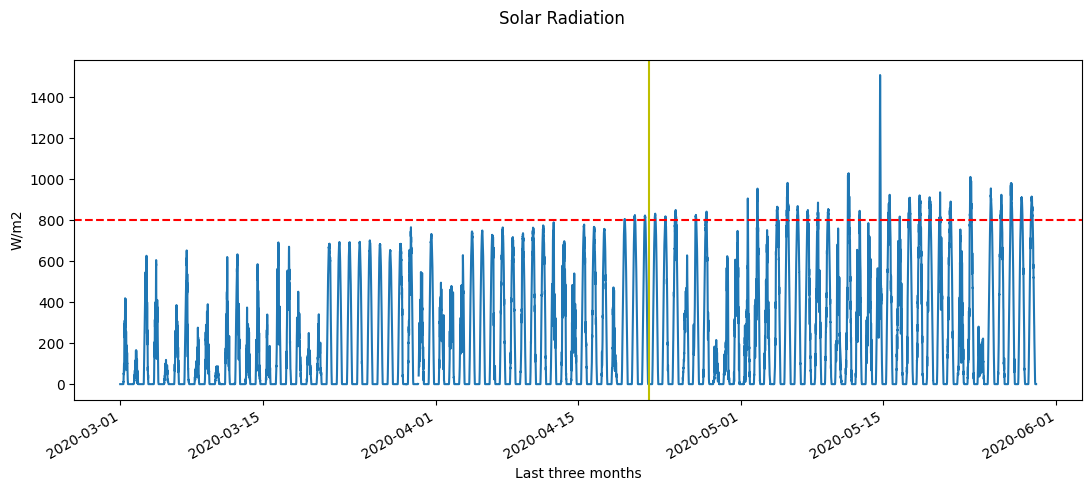

In [8]:
fig = plt.figure(figsize=(13, 5))
ax = conditions.loc['2020-03-01 00:00:00':]['Iglob'].plot()

plt.axhline(y = 800, color = 'r', linestyle = '--')
plt.axvline(x = '2020-04-22 00:00:00', color = 'y', linestyle = '-')

plt.suptitle('Solar Radiation')
plt.xlabel('Last three months')
plt.ylabel('W/m2')
plt.savefig('commons/Solar_radiation_last_3_months.jpg')
plt.show()

This is a first important clue that the grower could benefit from an automatic regulator lightning system. 

That automatic switch on the lights when the solar radiation is lower than a threshold and off them when higher!


# Timinig
Second clue, the lights are turned on or off almost everyday at the same time for 8 hours between 10am and 18pm

This with no regard of the weather outside

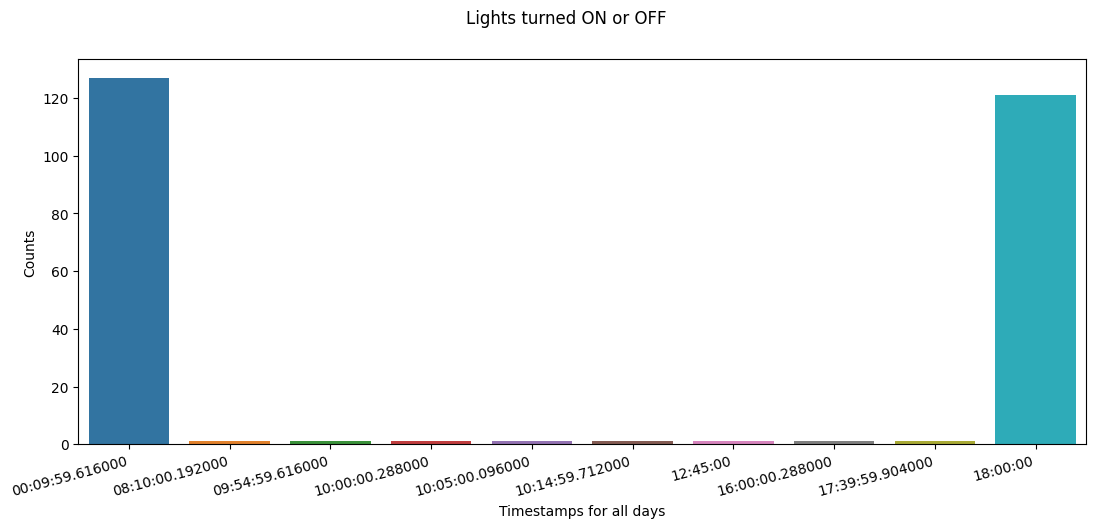

In [9]:
all_ = []
for day in np.unique(conditions.index.date):
    AssimLight = conditions[conditions.index.date==day]
    AssimLight = AssimLight.index[AssimLight.AssimLight==100]
    if len(AssimLight)> 0 :
        all_.append(AssimLight[1].time())
        all_.append(AssimLight[-1].time())
        
import pandas as pd
import seaborn as sns
df = pd.DataFrame({'first':all_})
fig = plt.figure(figsize=(13, 5))
ax = sns.countplot(x="first",data=df, order=sorted(df['first'].unique()))
plt.suptitle('Lights turned ON or OFF')
plt.xlabel('Timestamps for all days')
plt.xticks(rotation=15,ha='right')
plt.ylabel('Counts')
plt.savefig('commons/lights_on_or_off.jpeg')
plt.show()

# Illumination vs Plant grow
It stands to reason that there should be a positive correlation between illumination and plant growth and harvested yield.

It would be interesting to test if constant illumination radiation (artificial or not) is really necessary in all periods of plant growth. 

Maybe the sprout requires less light, than the adult plant and that saved light can be spend during the dark hours of the days when the fruits are maturing.



--------------
# 2. Day-ahead energy prediction
Energy for heating the greenhouse is one of the main cost drivers and natural gas prices can fluctuate substantially, possessing the risk for energy costs getting out of control. In order to mitigate this risk, a greenhouse grower can purchase energy hedge contracts through its energy supplier. 

To do so, he needs to have an idea of the amount of energy that he is going to consume on a certain day, so he can purchase the right number of contracts. 

The grower asked us to help him in making the best decision on a daily basis, when purchasing energy contracts for the next day (starting at 00:00h). 

Can the dataset be used to predict the energy consumption for the day ahead? 
If this is possible, what is the margin of error and how should this be taken into account? 

## Energy consumption: the parameter
Looking at the data the energy consumption is represented by the value: Heat_cons expressed in MJ/m2 per day.

Looking at Heat_cons plotted we can see that its value rumps up in January to gradually drop until the end of the experiment.


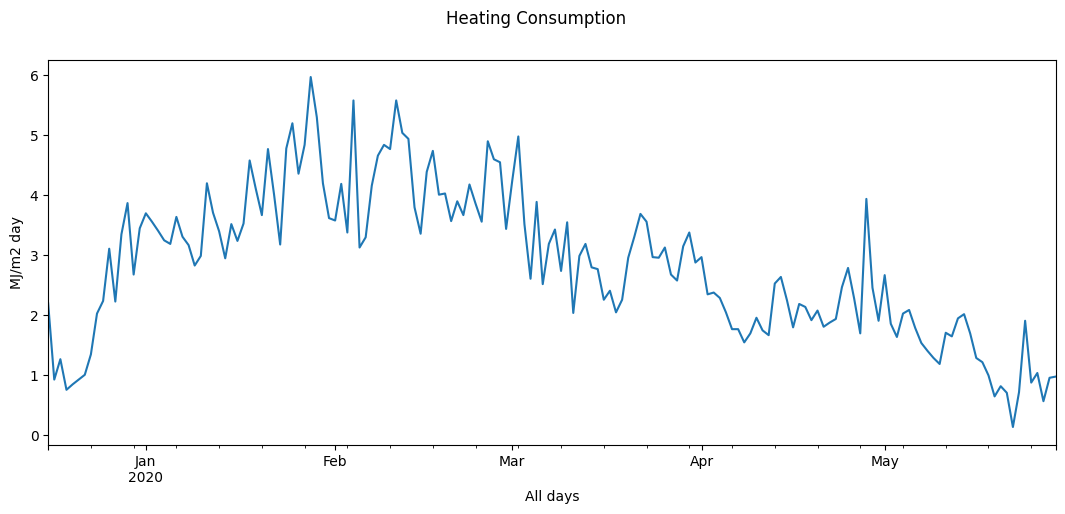

In [10]:
from datetime import datetime
resources = pd.read_csv('data/Resources.csv')
resources['date'] = pd.TimedeltaIndex(resources['%Time '], unit='d') + datetime(1899, 12, 30)
resources.index = pd.TimedeltaIndex(resources['%Time '], unit='d') + datetime(1899, 12, 30)
resources['date']=resources['date'].astype('str')

al.plot_data(
    data = resources['Heat_cons'],
    title = 'Heating Consumption',
    xlabel = 'All days',
    ylabel = 'MJ/m2 day',
    fig_name = 'commons/heating_consumption_all.jpg'
)

# Pearson’s correlation coefficient
Let’s check what is the most/least correlated value with Heat_cons


In [11]:
conditions['date'] = [day.date() for day in conditions.index]
conditions['date'] = conditions['date'].astype('str')

df = conditions.merge(resources[['Heat_cons', 'date']], how='left', left_on='date', right_on='date')
df.drop('date', axis=1, inplace=True)
df.index=conditions.index
df.head()

,AssimLight,BlackScr,CO2air,Cum_irr,EC_drain_PC,EnScr,HumDef,PipeGrow,PipeLow,Rhair,...,Iglob,PARout,Pyrgeo,RadSum,Rain,Rhout,Tout,Winddir,Windsp,Heat_cons
%time,,,,,,,,,,,,,,,,,,,,,
2019-12-16 00:00:00.000,0.0,35.0,472.0,0.4,4.0,100.0,7.2,0.0,45.2,60.6,...,0.0,0.0,-72.0,215.0,0.0,80.6,6.9,32.0,4.7,2.19
2019-12-16 00:04:59.808,0.0,85.0,501.0,0.5,4.0,100.0,6.9,0.0,43.6,61.4,...,0.0,0.0,-73.0,0.0,0.0,80.6,6.9,32.0,4.7,2.19
2019-12-16 00:09:59.616,0.0,96.0,489.0,0.5,4.0,100.0,7.2,0.0,42.3,60.9,...,0.0,0.0,-76.0,0.0,0.0,80.4,6.9,32.0,4.7,2.19
2019-12-16 00:15:00.288,0.0,96.0,497.0,0.5,4.0,100.0,6.7,0.0,41.2,62.5,...,0.0,0.0,-77.0,0.0,0.0,80.2,6.9,32.0,4.7,2.19
2019-12-16 00:20:00.096,0.0,96.0,477.0,0.5,4.0,100.0,6.7,0.0,41.2,62.7,...,0.0,0.0,-75.0,0.0,0.0,80.9,6.7,32.0,4.7,2.19


In [12]:
Heat_cons_corr = df.corr(numeric_only=False)["Heat_cons"]
Heat_cons_corr_cols = Heat_cons_corr[(Heat_cons_corr>=0.3)].index.tolist() + Heat_cons_corr[(Heat_cons_corr<=-0.3)].index.tolist()
df[Heat_cons_corr_cols].corr(numeric_only=False)["Heat_cons"].sort_values(ascending=False)

Heat_cons             1.000000
PipeLow               0.501922
pH_drain_PC           0.465426
assim_sp              0.448751
Rhair                 0.435673
Tot_PAR_Lamps         0.410375
assim_vip             0.385771
AssimLight            0.383408
Rhout                 0.363602
Pyrgeo                0.361489
int_white_sp          0.349493
int_red_sp            0.348335
int_blue_sp           0.348335
Windsp                0.344391
t_rail_min_vip        0.322416
t_rail_min_sp         0.304357
Iglob                -0.319261
PARout               -0.320679
RadSum               -0.353053
HumDef               -0.383148
VentLee              -0.387303
window_pos_lee_vip   -0.411684
window_pos_lee_sp    -0.411954
Tout                 -0.590621
Name: Heat_cons, dtype: float64

Heat_cons mostly correlates with values for:
- Humidity in and out
- Lightnings artificial or solar
- Heat emissions
- Wind and other weather 

With that in mind let’s see how can we predict the energy consumptions 

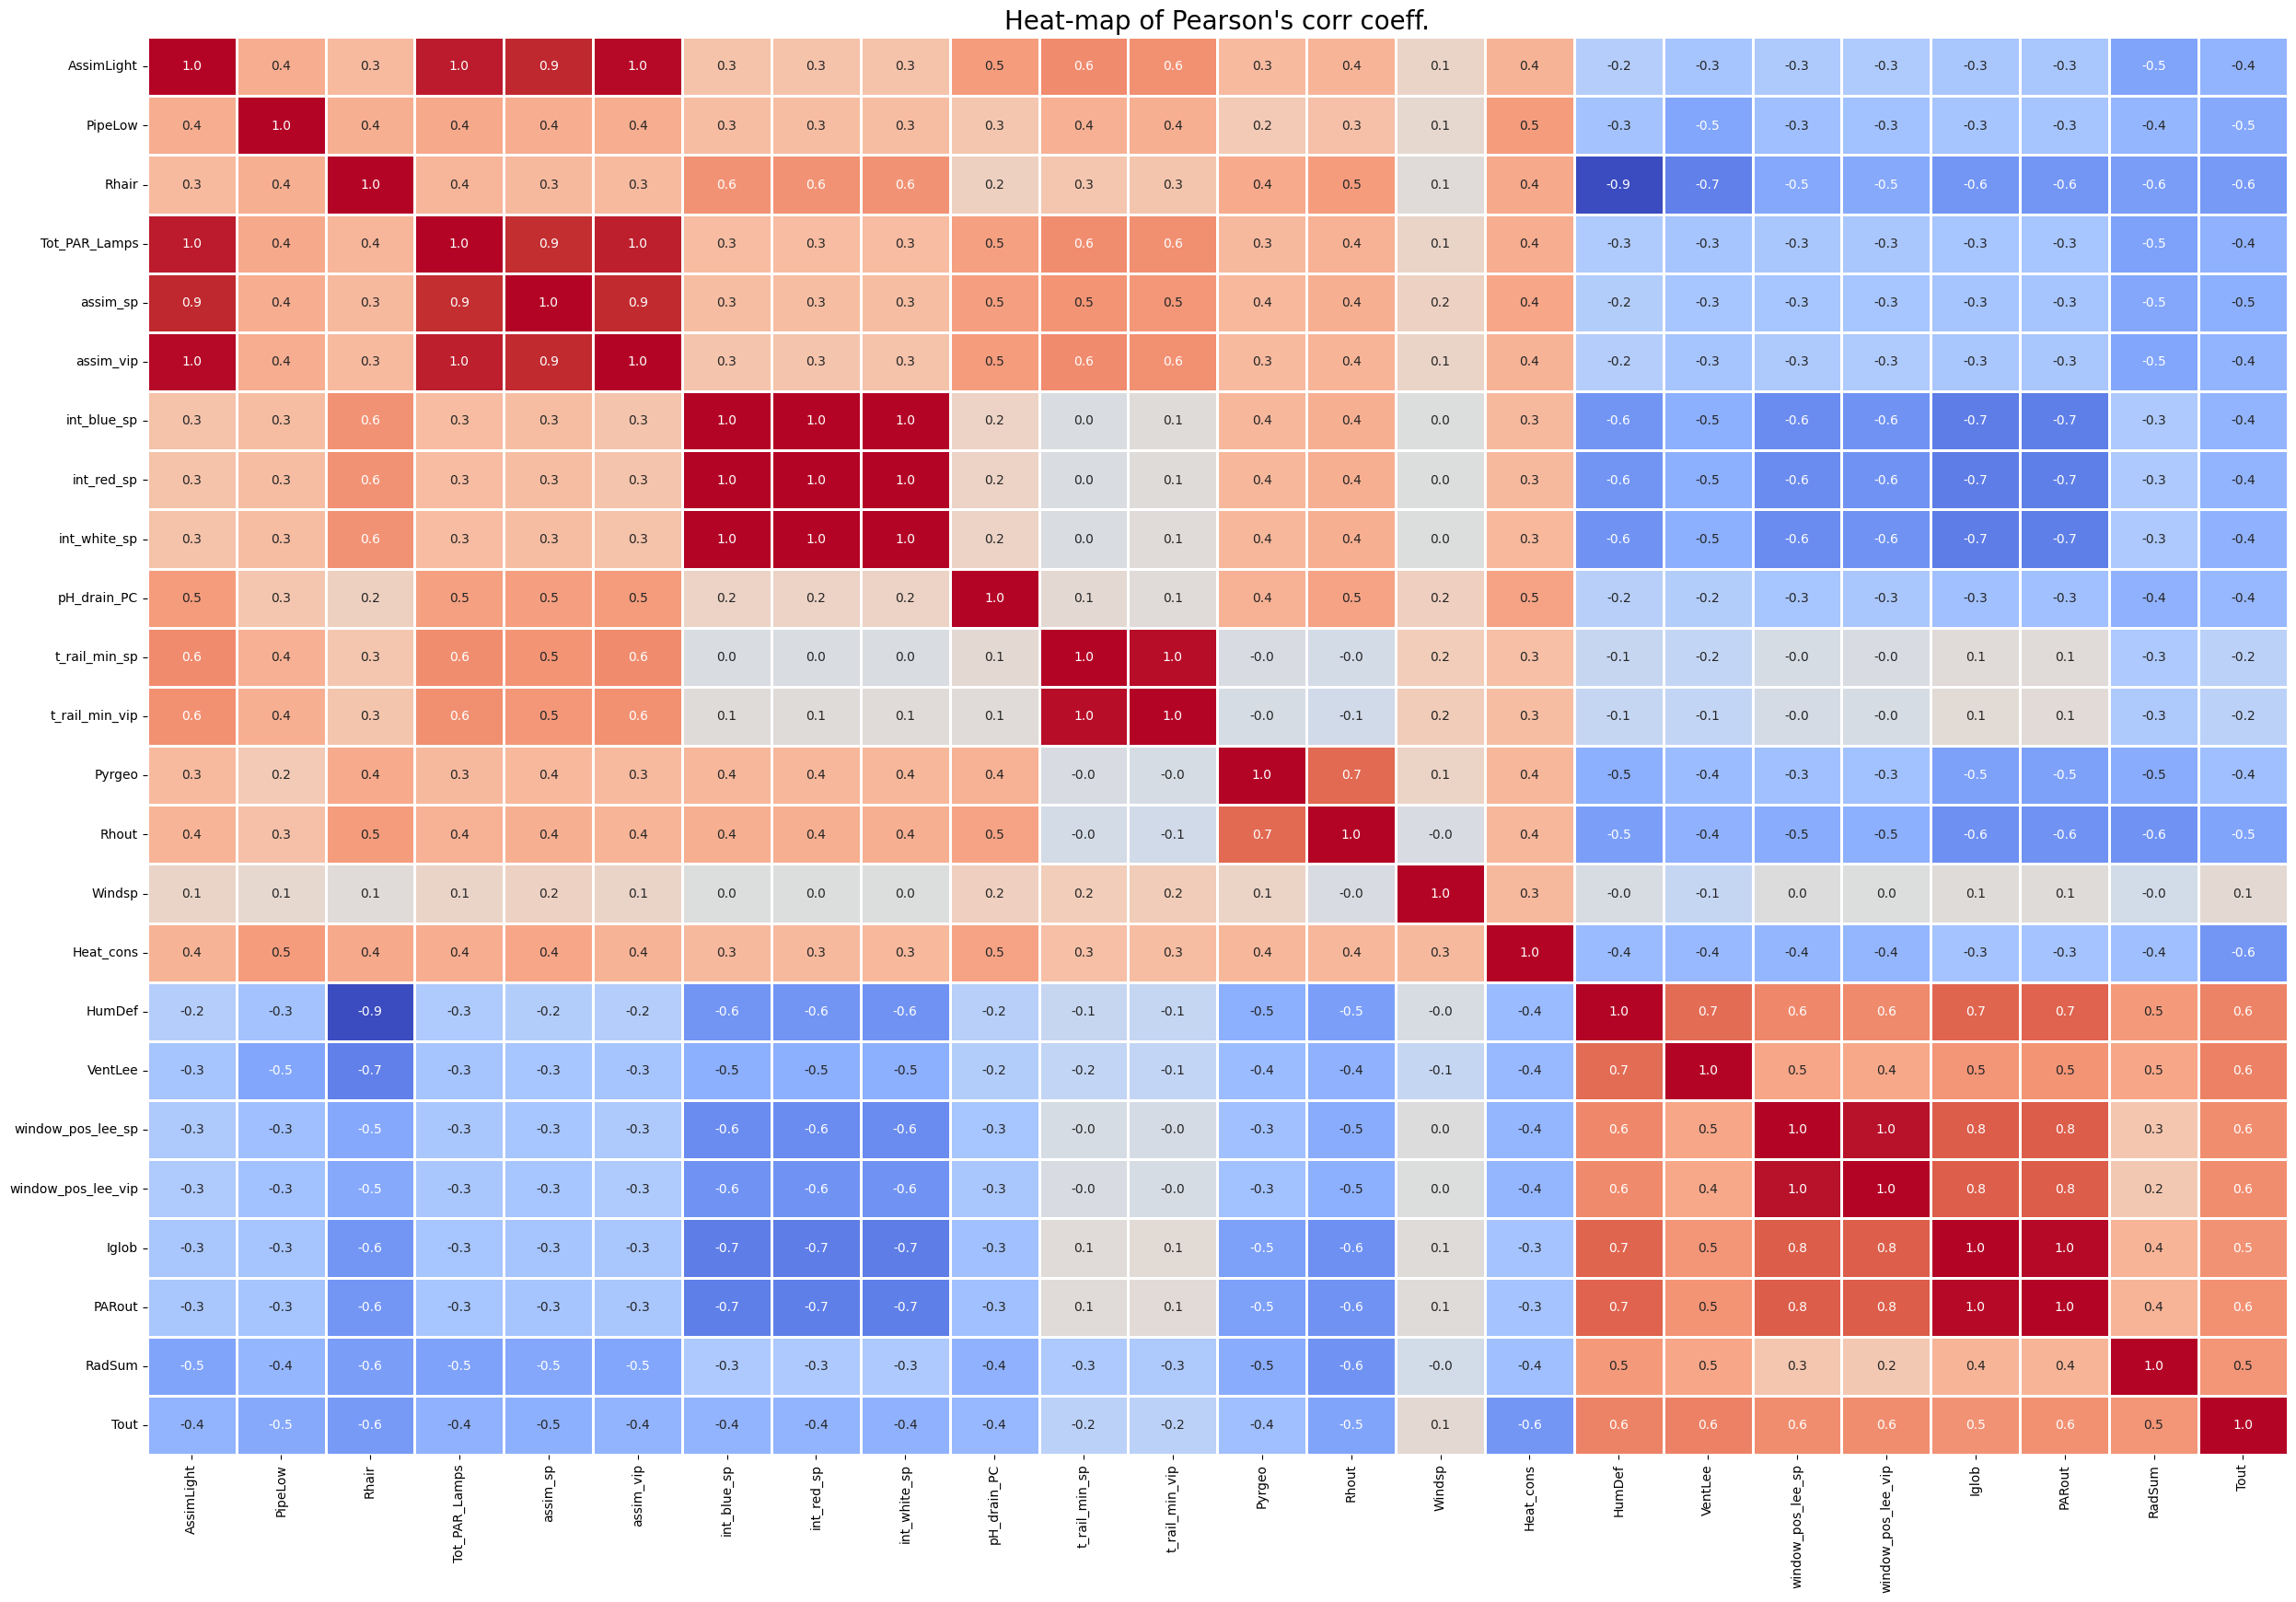

In [13]:
plt.figure(figsize=(30, 20))
sns.heatmap(
    df[Heat_cons_corr_cols].corr(numeric_only=False),
    annot=True,
    fmt='.1f',
    cmap='coolwarm',
    linewidths=1,
    cbar=False)
plt.title("Heat-map of Pearson's corr coeff.", fontsize = 20)
plt.savefig('commons/heat-map.jpg')
plt.show()

# Time series Forecast
In my DS career I have had little experience with time series forecasting. 

Therefore, for this exercise I want to start with the basic approaches and progress to more complexity.

However, before going ahead with the different approaches let’s identify the metrics we will use to judge them.

## Time series Metrics
There is no perfect metrics to evaluate time series

- R-squared or coefficient of determination. 
    - Best possible score is +1, but not the highest values possible
- Mean Squared Error (MSE)
    - Best score is 0 (no error)

### N-days rolling average
First method is n-days rolling average, this crude system is often very informative. Especially for small forecast like this one with only one-day ahead.

This means that the prediction for day x is given by the average of n days/entries prior: mean([x-n, …, x-1]) days.

Looking at the R^2 and MSE for testing all n-days rolling average from 1 to 30

We can see that 3 days prior is the best predictor for 1 day ahead.


<Figure size 640x480 with 0 Axes>

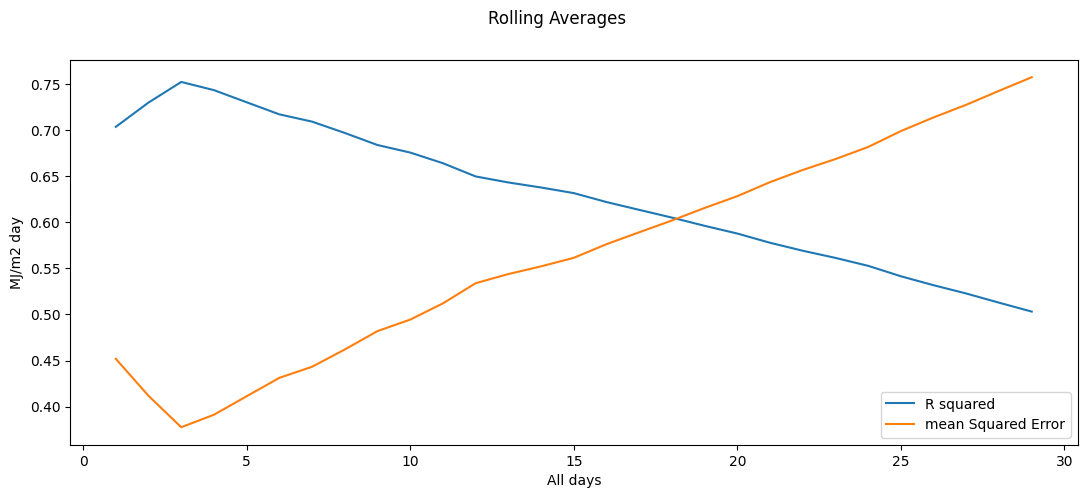

In [14]:
from sklearn.metrics import r2_score, mean_squared_error
r2_scores, mses = [], []
for days in range(1, 30):
    r2_scores.append(
        r2_score(
            resources.Heat_cons[1:], 
            resources.Heat_cons.rolling(days, min_periods=1, center=False).mean().values[:-1]
        )
    )
    mses.append(
        mean_squared_error(
            resources.Heat_cons[1:], 
            resources.Heat_cons.rolling(days, min_periods=1, center=False).mean().values[:-1]
        )
    )
    

metrics_df = pd.DataFrame({'r2_score':r2_scores, 'MSE':mses}, index=range(1, len(r2_scores)+1) )

fig = plt.figure()
ax = metrics_df.plot(figsize=(13, 5))
plt.legend(['R squared', 'mean Squared Error'], )
plt.suptitle('Rolling Averages')
plt.xlabel('All days')
plt.ylabel('MJ/m2 day')
plt.savefig('commons/rolling_averages.jpg')
plt.show()

This is the result compared with the real consumptions


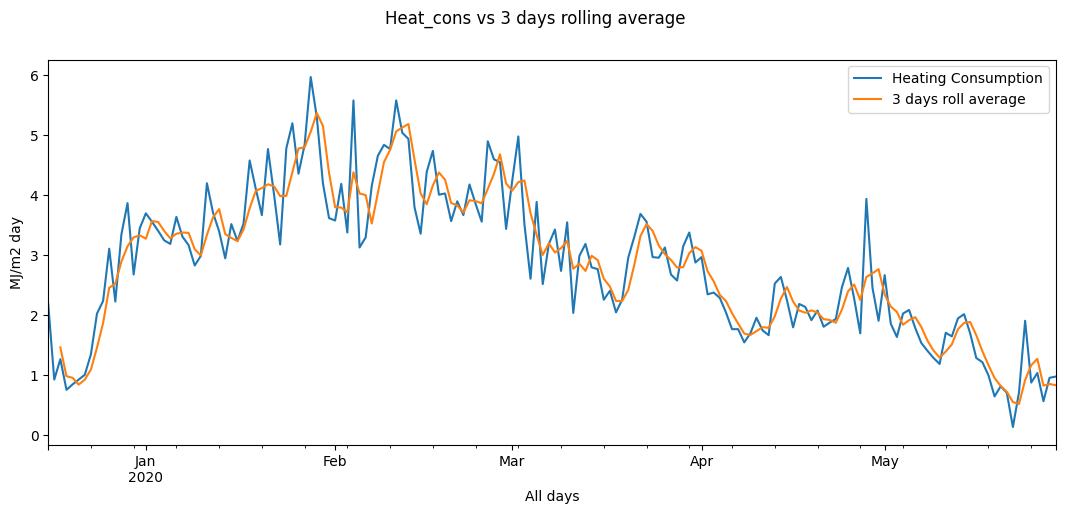

In [15]:
fig = plt.figure(figsize=(13, 5))

ax = resources.Heat_cons.plot()
ax = resources.Heat_cons.rolling(3, min_periods=3, center=False).mean().plot()
plt.legend(['Heating Consumption', '3 days roll average'])
plt.suptitle('Heat_cons vs 3 days rolling average')
plt.xlabel('All days')
plt.ylabel('MJ/m2 day')
plt.savefig('commons/3dra.jpg')
plt.show()

In [ ]:
from peax.src.forecasting import HeatingConsumption

resources = pd.read_csv('data/Resources.csv')
hc = HeatingConsumption.get_forecast(resources.Heat_cons)
#             r2_score       MSE
# GetAutoReg  0.723995  0.420653
# GetARIMA    0.762053  0.362650
# GetSARIMAX  0.763283  0.360776
hc